# Введение в обработку естественного языка

## Урок 2. Создание признакового пространства

Данные:

https://disk.yandex.ru/i/v5HM-ENiGXZVpQ

https://disk.yandex.ru/i/koR5eMCToCZS2Q

Задание 1.
Задание: обучите три классификатора:

1) на токенах с высокой частотой

2) на токенах со средней частотой

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

Задание 2.
найти фичи с наибольшей значимостью, и вывести их

Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

nltk.download('punkt', quiet=True)

# Отключить вывод ошибок
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('/kaggle/input/INP-Lesson-02/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('/kaggle/input/INP-Lesson-02/negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
def delete_pattern(text, pattern):
  return re.sub(pattern, ' ', text)

In [4]:
df['text'] = df['text'].apply(lambda x: x.lower())
# Замена пунктуации на пробелы
pattern_for_punctuation = r'[^\w\s]'
df['text'] = df['text'].apply(lambda x: delete_pattern(x, pattern_for_punctuation))
# Замена спец. символов на пробелы 
pattern_for_special_symb = r'[^a-zA-Z0-9]'
df['text'] = df['text'].apply(lambda x: delete_pattern(x, pattern_for_special_symb))
# Замена чисел на пробелы 
pattern_for_numbers = r'[^a-zA-Z]'
df['text'] = df['text'].apply(lambda x: delete_pattern(x, pattern_for_numbers))
# Удаление лишних пробелов
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label, 
                                                    test_size=0.25,
                                                    stratify=df.label)

In [6]:
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
y_train_word = y_train.copy()
y_train = [1 if elem == 'positive' else 0 for elem in y_train]
y_test_word = y_test.copy()
y_test = [1 if elem == 'positive' else 0 for elem in y_test]

In [8]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

467845


['first', 'timee', 'd', 'd', 'rt', 'katiacheh', 'rt', 'digger', 'dd', 'http']

In [10]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('rt', 38168),
 ('t', 34166),
 ('http', 33076),
 ('co', 33071),
 ('d', 19449),
 ('o', 3501),
 ('a', 2299),
 ('s', 1603),
 ('i', 1553),
 ('dd', 1311)]

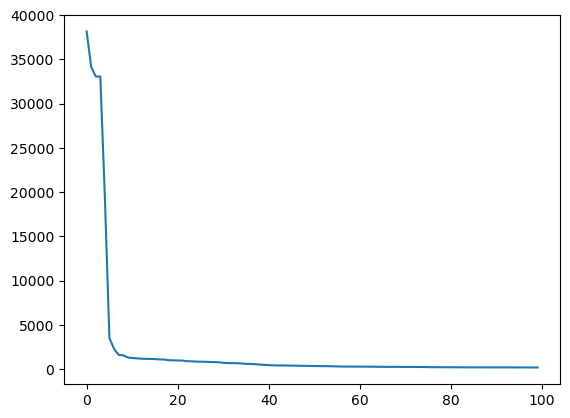

In [11]:
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

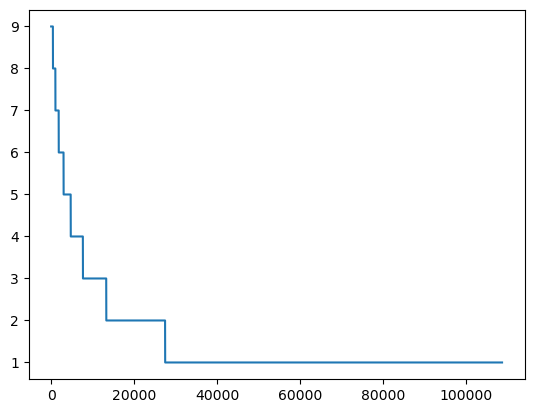

In [12]:
low_freq = [freq for word, freq in freq_dict_sorted if freq < 10]
plt.plot(low_freq)
plt.show()

In [13]:
very_low_freq = [freq for word, freq in freq_dict_sorted if freq <= 10]

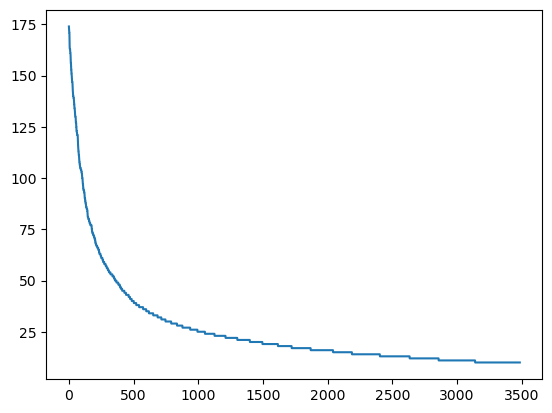

In [14]:
mean_freq = [freq for word, freq in freq_dict_sorted[100:-len(low_freq)]]
plt.plot(mean_freq)
plt.show()

In [15]:
len(freq_dict_sorted)

112197

In [16]:
len(low_freq), len(mean_freq), len(first_100_freqs)

(108611, 3486, 100)

In [17]:
vectorizer_high_freq = TfidfVectorizer(vocabulary=list(dict(freq_dict_sorted[:100]).keys()))

# Создаем the Bag-of-Words модель
bag_of_words_high_freq = vectorizer_high_freq.fit_transform(x_train.values)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_high_freq = vectorizer_high_freq.get_feature_names_out()
df_high_freq_train = pd.DataFrame(bag_of_words_high_freq.toarray(), columns = feature_names_high_freq)
bag_of_words_high_freq_test = vectorizer_high_freq.transform(x_test.values)
df_high_freq_test = pd.DataFrame(bag_of_words_high_freq_test.toarray(), columns = feature_names_high_freq)

In [18]:
classifier_high_freq = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_high_freq.fit(df_high_freq_train, y_train)
predictions_high_freq_train = classifier_high_freq.predict(df_high_freq_train)
predictions_high_freq_test = classifier_high_freq.predict(df_high_freq_test)

In [19]:
print(classification_report(predictions_high_freq_train, y_train))

              precision    recall  f1-score   support

           0       0.77      0.55      0.64    118722
           1       0.37      0.63      0.47     51403

    accuracy                           0.57    170125
   macro avg       0.57      0.59      0.55    170125
weighted avg       0.65      0.57      0.59    170125



In [20]:
print(classification_report(predictions_high_freq_test, y_test))

              precision    recall  f1-score   support

           0       0.77      0.54      0.64     39675
           1       0.37      0.62      0.46     17034

    accuracy                           0.57     56709
   macro avg       0.57      0.58      0.55     56709
weighted avg       0.65      0.57      0.59     56709



In [21]:
vectorizer_low_freq = TfidfVectorizer(vocabulary=list(dict(freq_dict_sorted[-len(low_freq):]).keys()))

# Создаем the Bag-of-Words модель
bag_of_words_low_freq = vectorizer_low_freq.fit_transform(x_train.values)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_low_freq = vectorizer_low_freq.get_feature_names_out()
df_low_freq_train = pd.DataFrame(bag_of_words_low_freq.toarray(), columns = feature_names_low_freq)
bag_of_words_low_freq_test = vectorizer_low_freq.transform(x_test.values)
df_low_freq_test = pd.DataFrame(bag_of_words_low_freq_test.toarray(), columns = feature_names_low_freq)

In [22]:
classifier_low_freq = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_low_freq.fit(df_low_freq_train, y_train)
predictions_low_freq_train = classifier_low_freq.predict(df_low_freq_train)
predictions_low_freq_test = classifier_low_freq.predict(df_low_freq_test)

In [23]:
print(classification_report(predictions_low_freq_train, y_train))

              precision    recall  f1-score   support

           0       0.97      0.69      0.80    118585
           1       0.57      0.95      0.71     51540

    accuracy                           0.77    170125
   macro avg       0.77      0.82      0.76    170125
weighted avg       0.85      0.77      0.78    170125



In [24]:
print(classification_report(predictions_low_freq_test, y_test))

              precision    recall  f1-score   support

           0       0.91      0.53      0.67     47825
           1       0.22      0.72      0.34      8884

    accuracy                           0.56     56709
   macro avg       0.57      0.62      0.51     56709
weighted avg       0.80      0.56      0.62     56709



In [25]:
vectorizer_mean_freq = TfidfVectorizer(vocabulary=list(dict(freq_dict_sorted[100:-len(low_freq)]).keys()))

# Создаем the Bag-of-Words модель
bag_of_words_mean_freq = vectorizer_mean_freq.fit_transform(x_train.values)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_mean_freq = vectorizer_mean_freq.get_feature_names_out()
df_mean_freq_train = pd.DataFrame(bag_of_words_mean_freq.toarray(), columns = feature_names_mean_freq)
bag_of_words_mean_freq_test = vectorizer_mean_freq.transform(x_test.values)
df_mean_freq_test = pd.DataFrame(bag_of_words_mean_freq_test.toarray(), columns = feature_names_mean_freq)

In [26]:
classifier_mean_freq = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_mean_freq.fit(df_mean_freq_train, y_train)
predictions_mean_freq_train = classifier_mean_freq.predict(df_mean_freq_train)
predictions_mean_freq_test = classifier_mean_freq.predict(df_mean_freq_test)

In [27]:
print(classification_report(predictions_mean_freq_train, y_train))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67    138126
           1       0.26      0.70      0.38     31999

    accuracy                           0.57    170125
   macro avg       0.57      0.62      0.52    170125
weighted avg       0.77      0.57      0.61    170125



In [28]:
print(classification_report(predictions_mean_freq_test, y_test))

              precision    recall  f1-score   support

           0       0.87      0.53      0.66     46052
           1       0.24      0.66      0.36     10657

    accuracy                           0.55     56709
   macro avg       0.56      0.59      0.51     56709
weighted avg       0.75      0.55      0.60     56709



In [29]:
classifier_mean_freq.coef_[0][:10]

array([ 0.2407361 ,  0.74156555,  0.47451122,  0.0578801 , -0.11161405,
        0.00459646,  0.72820986,  0.20102781,  0.25740353,  0.21444068])

In [30]:
classifier_mean_freq.feature_names_in_[0:10]

array(['styles', 'olga', 'na', 'green', 'sobchak', 'masha', 'and', 'way',
       'lol', 'killjoy'], dtype=object)

In [31]:
df_feature_importance = pd.DataFrame({'feature': list(classifier_mean_freq.feature_names_in_),
                                      'weight': list(classifier_mean_freq.coef_[0]),
                                      'abs_weight': [abs(elem) for elem in list(classifier_mean_freq.coef_[0])]})

In [32]:
df_feature_importance = df_feature_importance.sort_values(by='abs_weight', ascending=False)

In [33]:
print('Признаки с наибольшей значимостью')
df_feature_importance.head(10)

Признаки с наибольшей значимостью


,feature,weight,abs_weight
70,prisonero,-3.721891,3.721891
235,horanso,-3.101318,3.101318
301,ohoo,-3.029646,3.029646
144,ddddd,2.821061,2.821061
428,lponomarenko,-2.752672,2.752672
250,dtoropova,2.595520,2.595520
381,obnulyay,-2.559802,2.559802
935,eminofficial,2.538932,2.538932
105,oppa,-2.515019,2.515019
377,juljulianapai,2.466749,2.466749


In [34]:
words_with_normal_freq = [word for word, freq in freq_dict_sorted if freq > 5]
len(words_with_normal_freq)

6569

In [35]:
count_vectorizer = CountVectorizer(vocabulary = words_with_normal_freq)
x_train_count = count_vectorizer.fit_transform(x_train.values)
x_test_count = count_vectorizer.transform(x_test.values)
classifier_count_vect = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_count_vect.fit(x_train_count, y_train)
predictions_train_count = classifier_count_vect.predict(x_train_count)
predictions_test_count = classifier_count_vect.predict(x_test_count)

In [36]:
print(classification_report(predictions_train_count, y_train))

              precision    recall  f1-score   support

           0       0.78      0.59      0.67    111183
           1       0.47      0.69      0.56     58942

    accuracy                           0.62    170125
   macro avg       0.62      0.64      0.61    170125
weighted avg       0.67      0.62      0.63    170125



In [37]:
print(classification_report(predictions_test_count, y_test))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65     37193
           1       0.44      0.65      0.53     19516

    accuracy                           0.60     56709
   macro avg       0.60      0.61      0.59     56709
weighted avg       0.65      0.60      0.61     56709



In [38]:
tfidf_vectorizer = TfidfVectorizer(vocabulary = words_with_normal_freq)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train.values)
x_test_tfidf = tfidf_vectorizer.transform(x_test.values)
classifier_tfidf_vect = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_tfidf_vect.fit(x_train_tfidf, y_train)
predictions_train_tfidf = classifier_tfidf_vect.predict(x_train_tfidf)
predictions_test_tfidf = classifier_tfidf_vect.predict(x_test_tfidf)

In [39]:
print(classification_report(predictions_train_tfidf, y_train))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67    109243
           1       0.48      0.68      0.56     60882

    accuracy                           0.62    170125
   macro avg       0.63      0.64      0.62    170125
weighted avg       0.67      0.62      0.63    170125



In [40]:
print(classification_report(predictions_test_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65     36569
           1       0.46      0.65      0.54     20140

    accuracy                           0.60     56709
   macro avg       0.60      0.61      0.59     56709
weighted avg       0.65      0.60      0.61     56709



In [41]:
n_features_for_hash = [2 ** i for i in range(18)]

In [42]:
for numb in n_features_for_hash:
    print('n_features =', numb)
    hash_vectorizer = HashingVectorizer(n_features=numb)
    x_train_hash = hash_vectorizer.fit_transform(x_train.values)
    x_test_hash = hash_vectorizer.transform(x_test.values)
    classifier_hash_vect = LogisticRegression(solver='lbfgs', max_iter=1000)
    classifier_hash_vect.fit(x_train_hash, y_train)
    predictions_train_hash = classifier_hash_vect.predict(x_train_hash)
    predictions_test_hash = classifier_hash_vect.predict(x_test_hash)
    print(classification_report(predictions_test_hash, y_test))
    print()

n_features = 1
              precision    recall  f1-score   support

           0       0.20      0.43      0.27     12945
           1       0.74      0.49      0.59     43764

    accuracy                           0.48     56709
   macro avg       0.47      0.46      0.43     56709
weighted avg       0.62      0.48      0.52     56709


n_features = 2
              precision    recall  f1-score   support

           0       0.69      0.55      0.61     35308
           1       0.44      0.59      0.51     21401

    accuracy                           0.56     56709
   macro avg       0.57      0.57      0.56     56709
weighted avg       0.60      0.56      0.57     56709


n_features = 4
              precision    recall  f1-score   support

           0       0.67      0.55      0.60     34402
           1       0.46      0.59      0.52     22307

    accuracy                           0.57     56709
   macro avg       0.57      0.57      0.56     56709
weighted avg       0.59    

In [43]:
from nltk.tokenize import WordPunctTokenizer

In [44]:
tokenizer = WordPunctTokenizer()

In [45]:
train_corpus = " ".join(x_train.values)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)

In [46]:
from collections import Counter

In [47]:
tokens_filtered = [word for word in tokens]

In [48]:
index_count = 0
vocabulary_inv = {}
vocabulary = {}
for key in dict(Counter(tokens_filtered).most_common(3000)).keys():
  vocabulary_inv[index_count] = key
  vocabulary[key] = index_count
  index_count += 1

In [49]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [50]:
max_len = len(vocabulary)

In [51]:
x_train_for_nn = np.array([text_to_sequence(text, max_len) for text in x_train.values], dtype=np.int32)
x_test_for_nn = np.array([text_to_sequence(text, max_len) for text in x_test.values], dtype=np.int32)

In [52]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [54]:
class Net(nn.Module):
    def __init__(self, vocab_size=3000, embedding_dim = 256, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [55]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [56]:
batch_size = 128
max_words = 50
epochs = 2

model = Net(vocab_size=len(vocabulary)).to(device)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()
    
train_dataset = DataWrapper(x_train_for_nn, np.array(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%400 == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(3000, 256)
  (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 866561
Train epoch 1/2
Step 0: loss=0.7256662845611572
Step 400: loss=0.5930626392364502
Step 800: loss=0.6035126447677612
Step 1200: loss=0.7043361663818359
Train epoch 2/2
Step 0: loss=0.5459377765655518
Step 400: loss=0.6473375558853149
Step 800: loss=0.6147239208221436
Step 1200: loss=0.6553319692611694


In [57]:
test_dataset = DataWrapper(x_test_for_nn, np.array(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [58]:
model.eval()
list_accuracy = []
for data in test_loader:
  test_outputs = model(data[0].to(device))
  label = data[1].to(device)
  predict = torch.max(test_outputs, 1)[1]
  break
print(classification_report(predict.cpu(), label.cpu()))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73       128
           1       0.00      0.00      0.00         0

    accuracy                           0.57       128
   macro avg       0.50      0.29      0.36       128
weighted avg       1.00      0.57      0.73       128



In [59]:
list_accuracy = []
for data in test_loader:
  test_outputs = model(data[0].to(device))
  label = data[1].to(device)
  predict = torch.max(test_outputs, 1)[1]
  list_accuracy.append((predict == label).sum()/predict.shape[0])
np.mean([elem.cpu() for elem in list_accuracy])

0.49277872